In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import scipy as sp
from scipy import stats

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

In [31]:
# 1. Read the data
df_all = pd.read_csv("all_data_food.csv")  # Change the file path if necessary

# 2. Main gram-based components (non-overlapping)
main_gram_columns = [
    "Fat", "Carbohydrates", "Protein", "Dietary Fiber", "Water"
]

# 3. Calculate the sum of these components
df_all["Sum_g_components"] = df_all[main_gram_columns].sum(axis=1)

# 4. Exclude entries where the sum exceeds 100g
df_partial_clean = df_all[df_all["Sum_g_components"] <= 100].copy()

# 5. Sum the fat subcomponents
df_partial_clean["Sum_subfats"] = (
    df_partial_clean["Saturated Fats"].fillna(0) +
    df_partial_clean["Monounsaturated Fats"].fillna(0) +
    df_partial_clean["Polyunsaturated Fats"].fillna(0)
)

# 6. Exclude entries where total fat is less than the sum of subfats
df_clean = df_partial_clean[df_partial_clean["Fat"].fillna(0) >= df_partial_clean["Sum_subfats"]].copy()

# 7. Save the cleaned dataset (optional):
# df_clean.to_csv("cleaned_food_dataset.csv", index=False)

# 8. Summary
print(f"Cleaned dataset contains {df_clean.shape[0]} rows.")

Cleaned dataset contains 934 rows.


In [32]:
# Clean zero values
df_clean = df_clean.loc[~(df_clean.drop('cluster', axis=1, errors='ignore') == 0).all(axis=1)]

In [33]:
df_clean.shape

(934, 37)

In [34]:
df_clean.drop(columns=["Sum_g_components", "Sum_subfats"], inplace=True)

In [35]:
df_clean.shape

(934, 35)

In [36]:
from scipy.stats import zscore

# Take numeric columns
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns

# Z-score
z_scores = np.abs(zscore(df_clean[numeric_cols]))

# Threshold
threshold = 3.5
outliers = (z_scores > threshold).any(axis=1)

# Outliers
df_no_outliers = df_clean[~outliers].copy()

print(f"Number of data after excluding outliers: {df_no_outliers.shape[0]} row")


Number of data after excluding outliers: 747 row


In [37]:
print(df_clean.columns.tolist())

['food', 'Caloric Value', 'Fat', 'Saturated Fats', 'Monounsaturated Fats', 'Polyunsaturated Fats', 'Carbohydrates', 'Sugars', 'Protein', 'Dietary Fiber', 'Cholesterol', 'Sodium', 'Water', 'Vitamin A', 'Vitamin B1', 'Vitamin B11', 'Vitamin B12', 'Vitamin B2', 'Vitamin B3', 'Vitamin B5', 'Vitamin B6', 'Vitamin C', 'Vitamin D', 'Vitamin E', 'Vitamin K', 'Calcium', 'Copper', 'Iron', 'Magnesium', 'Manganese', 'Phosphorus', 'Potassium', 'Selenium', 'Zinc', 'Nutrition Density']


In [38]:
macro_columns = [
    "Fat", "Carbohydrates", "Sugars",
    "Protein", "Dietary Fiber", "Water"
]
# "Caloric Value", 
micro_columns = [
    "Vitamin A", "Vitamin B1", "Vitamin B11", "Vitamin B12", "Vitamin B2",
    "Vitamin B3", "Vitamin B5", "Vitamin B6", "Vitamin C", "Vitamin D",
    "Vitamin E", "Vitamin K", "Calcium", "Copper", "Iron", "Magnesium",
    "Manganese", "Phosphorus", "Potassium", "Selenium", "Zinc"
]

### 2 PCA

In [39]:
df_macro = df_clean[["food"] + macro_columns].copy()
#df_macro = df_clean[["food"] + micro_columns].copy()

In [40]:
display(df_macro)

,food,Fat,Carbohydrates,Sugars,Protein,Dietary Fiber,Water
0,cream cheese,5.000,0.8,0.500,0.900,0.000,7.6
1,neufchatel cheese,19.400,3.1,2.700,7.800,0.000,53.6
2,requeijao cremoso light catupiry,3.600,0.9,3.400,0.800,0.100,0.0
3,ricotta cheese,2.000,1.5,0.091,1.500,0.000,14.7
4,cream cheese low fat,2.300,1.2,0.900,1.200,0.000,10.0
...,...,...,...,...,...,...,...
2388,pepeao dried,0.100,19.4,0.000,1.200,0.000,2.7
2389,truffles,4.100,5.4,4.600,0.700,0.300,1.6
2390,jews ear,0.095,6.7,0.000,0.500,0.000,91.7
2391,enoki mushrooms,0.099,0.2,0.034,0.062,0.089,2.7


In [41]:
dfall = df_macro

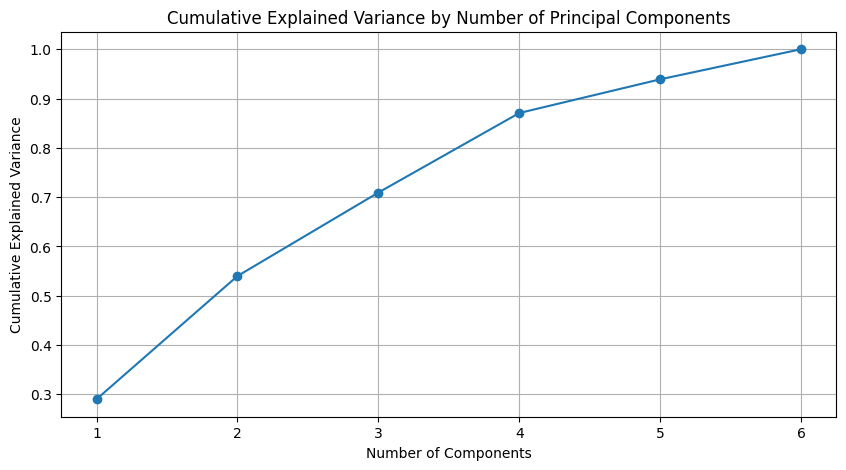


Key PCA Loadings (Top 5 features for the first 3 principal components):
  Top PC1 Features  PC1 Loadings Top PC2 Features  PC2 Loadings  \
0    Carbohydrates      0.601694          Protein      0.663410   
1           Sugars      0.566682            Water      0.467941   
2            Water      0.395058              Fat      0.383371   
3          Protein      0.290158    Carbohydrates      0.327397   
4    Dietary Fiber      0.265895    Dietary Fiber      0.255496   

  Top PC3 Features  PC3 Loadings  
0              Fat      0.578507  
1            Water      0.472543  
2           Sugars      0.468169  
3    Dietary Fiber      0.450120  
4    Carbohydrates      0.142274  


In [42]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# === 1. Select numeric columns ===
numeric_columns = dfall.select_dtypes(include=[np.number]).columns
X = dfall[numeric_columns].dropna()  # remove rows with missing values

# === 2. Standardize the data ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === 3. Apply PCA ===
pca = PCA()
X_pca = pca.fit_transform(X_scaled)

# === 4. Explained Variance Plot ===
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10, 5))
plt.plot(np.arange(1, len(explained_variance) + 1), np.cumsum(explained_variance), marker='o')
plt.title("Cumulative Explained Variance by Number of Principal Components")
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.grid(True)
plt.show()

# === 5. PCA Loadings Matrix ===
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=numeric_columns
)

# === 6. Top contributing features for PC1, PC2, PC3 ===
top_features_pc1 = loadings["PC1"].abs().sort_values(ascending=False).head(5)
top_features_pc2 = loadings["PC2"].abs().sort_values(ascending=False).head(5)
top_features_pc3 = loadings["PC3"].abs().sort_values(ascending=False).head(5)

top_features_df = pd.DataFrame({
    "Top PC1 Features": top_features_pc1.index,
    "PC1 Loadings": top_features_pc1.values,
    "Top PC2 Features": top_features_pc2.index,
    "PC2 Loadings": top_features_pc2.values,
    "Top PC3 Features": top_features_pc3.index,
    "PC3 Loadings": top_features_pc3.values,
})

print("\nKey PCA Loadings (Top 5 features for the first 3 principal components):")
print(top_features_df)


### PCA Evaluation  
5 components are sufficient to retain over 90% of the variance.

This is a widely accepted threshold, so the choice is fully justified. Using more may retain noise, while fewer components may lead to information loss.


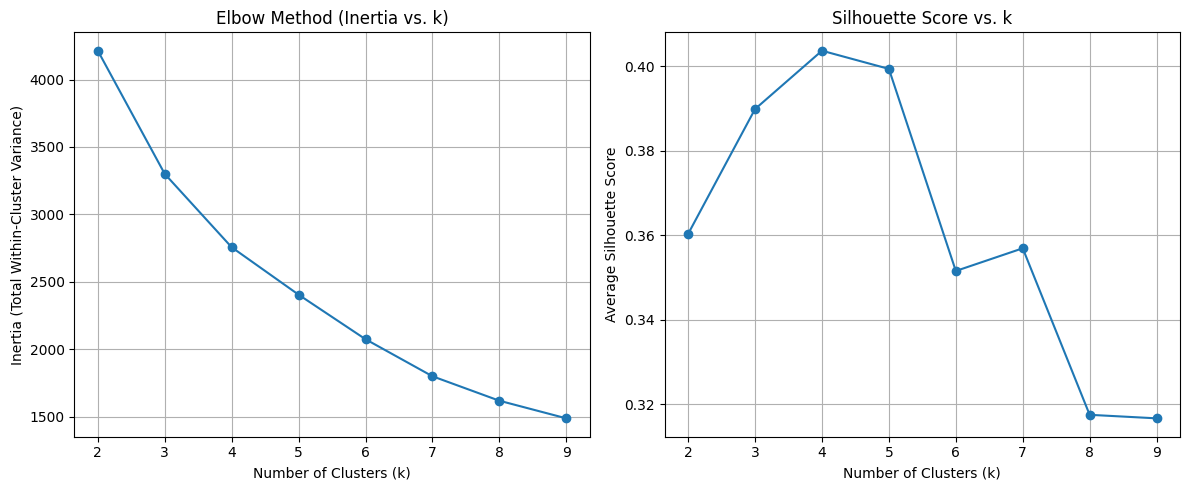

In [43]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# First 5 components from PCA-reduced data
X_pca_subset = X_pca[:, :5]

# Range of cluster numbers
K_range = range(2, 10)
inertias = []
silhouette_scores = []

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_pca_subset)
    
    # Elbow: total within-cluster variance (inertia)
    inertias.append(kmeans.inertia_)
    
    # Silhouette: quality of separation between clusters
    labels = kmeans.labels_
    score = silhouette_score(X_pca_subset, labels)
    silhouette_scores.append(score)

# === Plots ===
plt.figure(figsize=(12, 5))

# Elbow plot
plt.subplot(1, 2, 1)
plt.plot(K_range, inertias, marker='o')
plt.title("Elbow Method (Inertia vs. k)")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Inertia (Total Within-Cluster Variance)")
plt.grid(True)

# Silhouette plot
plt.subplot(1, 2, 2)
plt.plot(K_range, silhouette_scores, marker='o')
plt.title("Silhouette Score vs. k")
plt.xlabel("Number of Clusters (k)")
plt.ylabel("Average Silhouette Score")
plt.grid(True)

plt.tight_layout()
plt.show()


### Assistant’s Suggestion: Testing K-1 and K+1  

This is a very effective strategy because:

- If the score at K=3 is very close to that at K=4 → a simpler structure might be preferable.  
- If the score drops significantly at K=5 → K=4 is likely the true optimum.

In that case:  
- K=3: ~0.39  
- K=4: ~0.405  
- K=5: ~0.398


#### Second part of Analysis

In [44]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

X_eval = X_pca[:, :5]
k_values = [3, 4, 5]
results = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_eval)
    
    sil = silhouette_score(X_eval, labels)
    db = davies_bouldin_score(X_eval, labels)
    ch = calinski_harabasz_score(X_eval, labels)
    
    results.append({
        "k": k,
        "Silhouette Score (↑)": sil,
        "Davies-Bouldin (↓)": db,
        "Calinski-Harabasz (↑)": ch
    })

# Results in tables
results_df = pd.DataFrame(results)
print(results_df)


   k  Silhouette Score (↑)  Davies-Bouldin (↓)  Calinski-Harabasz (↑)
0  3              0.389898            1.334406             276.775471
1  4              0.403723            1.083650             281.915238
2  5              0.399412            1.069624             276.113947


### Conclusion

Choosing **K = 4** is statistically sound and well-justified.  
**K = 5** performs slightly better only in the Davies-Bouldin score, but falls behind in the other two metrics.

Therefore, **K = 4** is the best choice both **intuitively** (via visualizations) and **analytically** (via internal metrics).


In [45]:
from sklearn.cluster import KMeans

# 5 components
X_pca_subset = X_pca[:, :5]

# KMeans 
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_pca_subset)

In [46]:
# Add cluster info into original DataFrame
df_clustered = dfall.copy()
df_clustered["Cluster"] = cluster_labels

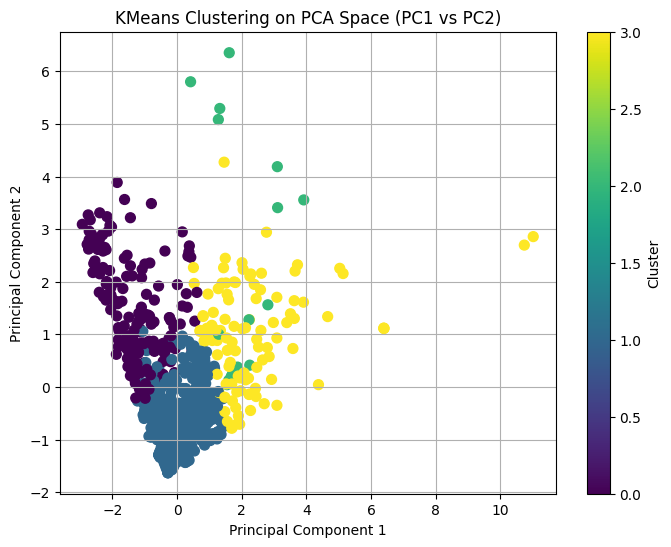

In [47]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis', s=50)
plt.title("KMeans Clustering on PCA Space (PC1 vs PC2)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.colorbar(scatter, label="Cluster")
plt.show()

In [48]:
# Calculate avg by using numeric columns
cluster_profiles = df_clustered.groupby("Cluster").mean(numeric_only=True)

# Results
print(cluster_profiles)

              Fat  Carbohydrates     Sugars    Protein  Dietary Fiber  \
Cluster                                                                 
0        5.216709       5.775972   1.019441  10.898324       0.683849   
1        3.811259       6.108778   0.991051   2.383687       0.531044   
2        4.931579      20.368421   1.394737  10.057895      13.705263   
3        8.329236      33.685849  13.368170   3.734726       1.566387   

             Water  
Cluster             
0        51.153631  
1         7.985249  
2         2.147368  
3        10.351915  


## Notable Clusters:

**Cluster 2:** Very rich in fiber and protein — a highly distinctive nutritional profile.

**Cluster 3:** High energy density (due to high sugar and fat levels) — hence stands out clearly along PC1.


In [49]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# X_scaled: standardize edilmiş veri (PCA uygulanmış olabilir veya olmayabilir)
labels = kmeans.labels_

# 1. Silhouette Score
#sil_score = silhouette_score(X_scaled, labels)

# 2. Davies-Bouldin Index
#db_score = davies_bouldin_score(X_scaled, labels)

# 3. Calinski-Harabasz Index
#ch_score = calinski_harabasz_score(X_scaled, labels)

sil_score = silhouette_score(X_pca_subset, labels)
db_score = davies_bouldin_score(X_pca_subset, labels)
ch_score = calinski_harabasz_score(X_pca_subset, labels)

# Results
print(f"Silhouette Score:        {sil_score:.3f}  (↑ better)")
print(f"Davies-Bouldin Index:    {db_score:.3f}  (↓ better)")
print(f"Calinski-Harabasz Score: {ch_score:.3f}  (↑ better)")

Silhouette Score:        0.404  (↑ better)
Davies-Bouldin Index:    1.084  (↓ better)
Calinski-Harabasz Score: 281.915  (↑ better)


In [50]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

def plot_cluster_radar_profiles(df_clustered, macro_columns, cluster_col="Cluster"):
    """
    Displays cluster profiles using radar plots in both unscaled and scaled forms.

    Parameters:
    - df_clustered: DataFrame containing cluster assignments (e.g., df_clustered)
    - macro_columns: List of numeric features to be plotted (e.g., ["Fat", "Protein", ...])
    - cluster_col: Name of the column that contains cluster labels (default: "Cluster")
    """
    # Compute mean values per cluster
    cluster_profiles = df_clustered.groupby(cluster_col)[macro_columns].mean()

    # Create scaled version using MinMaxScaler
    scaler = MinMaxScaler()
    cluster_profiles_scaled = pd.DataFrame(
        scaler.fit_transform(cluster_profiles),
        columns=cluster_profiles.columns,
        index=cluster_profiles.index
    )

    # Radar plot configuration
    labels = macro_columns
    num_vars = len(labels)
    angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
    angles += angles[:1]

    fig, axs = plt.subplots(1, 2, figsize=(14, 7), subplot_kw=dict(polar=True))

    # 1. Unscaled plot
    ax = axs[0]
    for i, row in cluster_profiles.iterrows():
        values = row.tolist() + [row.tolist()[0]]
        ax.plot(angles, values, label=f"Cluster {i}", linewidth=2)
    ax.set_title("Unscaled Nutritional Profiles", size=14)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10)
    ax.set_yticklabels([])

    # 2. Scaled plot
    ax = axs[1]
    for i, row in cluster_profiles_scaled.iterrows():
        values = row.tolist() + [row.tolist()[0]]
        ax.plot(angles, values, label=f"Cluster {i}", linewidth=2)
    ax.set_title("Scaled Nutritional Profiles", size=14)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(labels, fontsize=10)
    ax.set_yticklabels([])

    plt.suptitle("Comparison of Cluster Nutritional Profiles", size=16)
    plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.1))
    plt.tight_layout()
    plt.show()


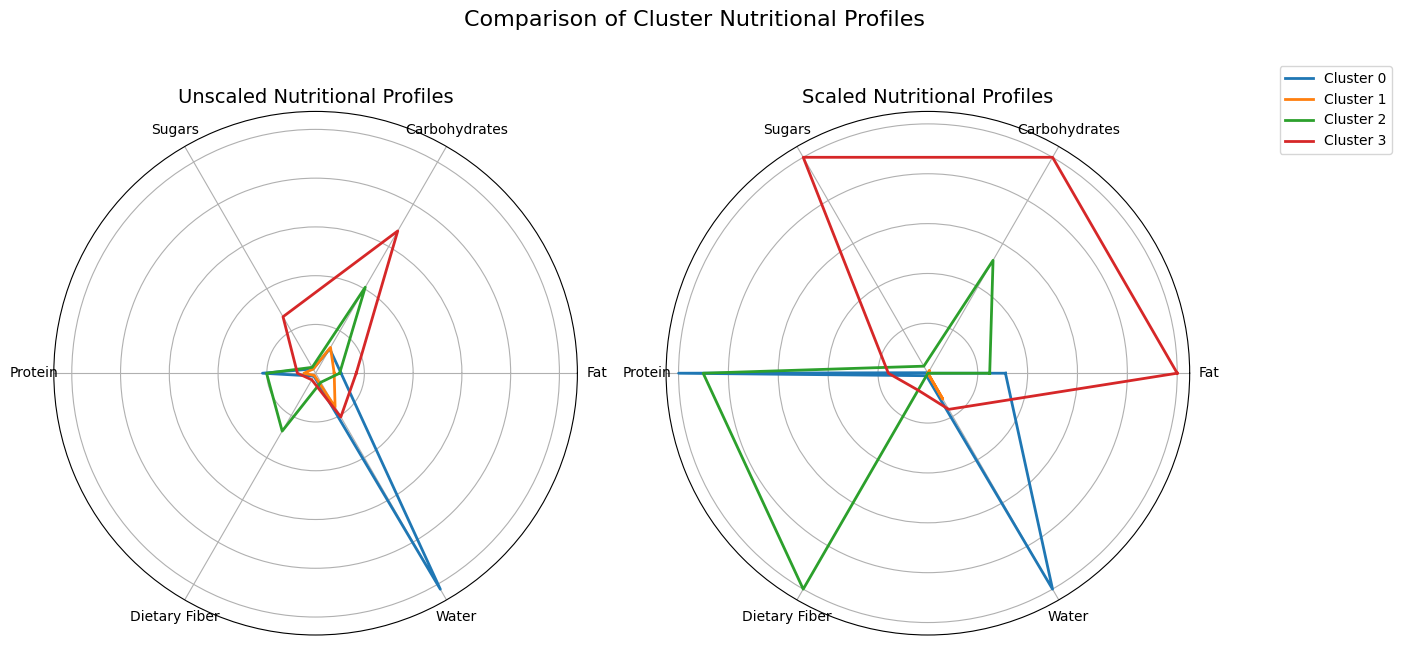

In [51]:
macro_columns = ["Fat", "Carbohydrates", "Sugars", "Protein", "Dietary Fiber", "Water"]
plot_cluster_radar_profiles(df_clustered, macro_columns)

### Right Plot: Scaled (Comparative View)
This is the most useful visualization for interpreting clusters:

##### Cluster | Dominant Traits
* **0** – Highest water, moderate protein → likely fresh produce or dairy
* **1** – No strong dominance → moderate overall profile, possibly mixed foods
* **2** – Highest in protein and fiber → healthy profile, likely grains/legumes
* **3** – Highest in fat, carbohydrates, and sugar → energy-dense, possibly fast food or desserts


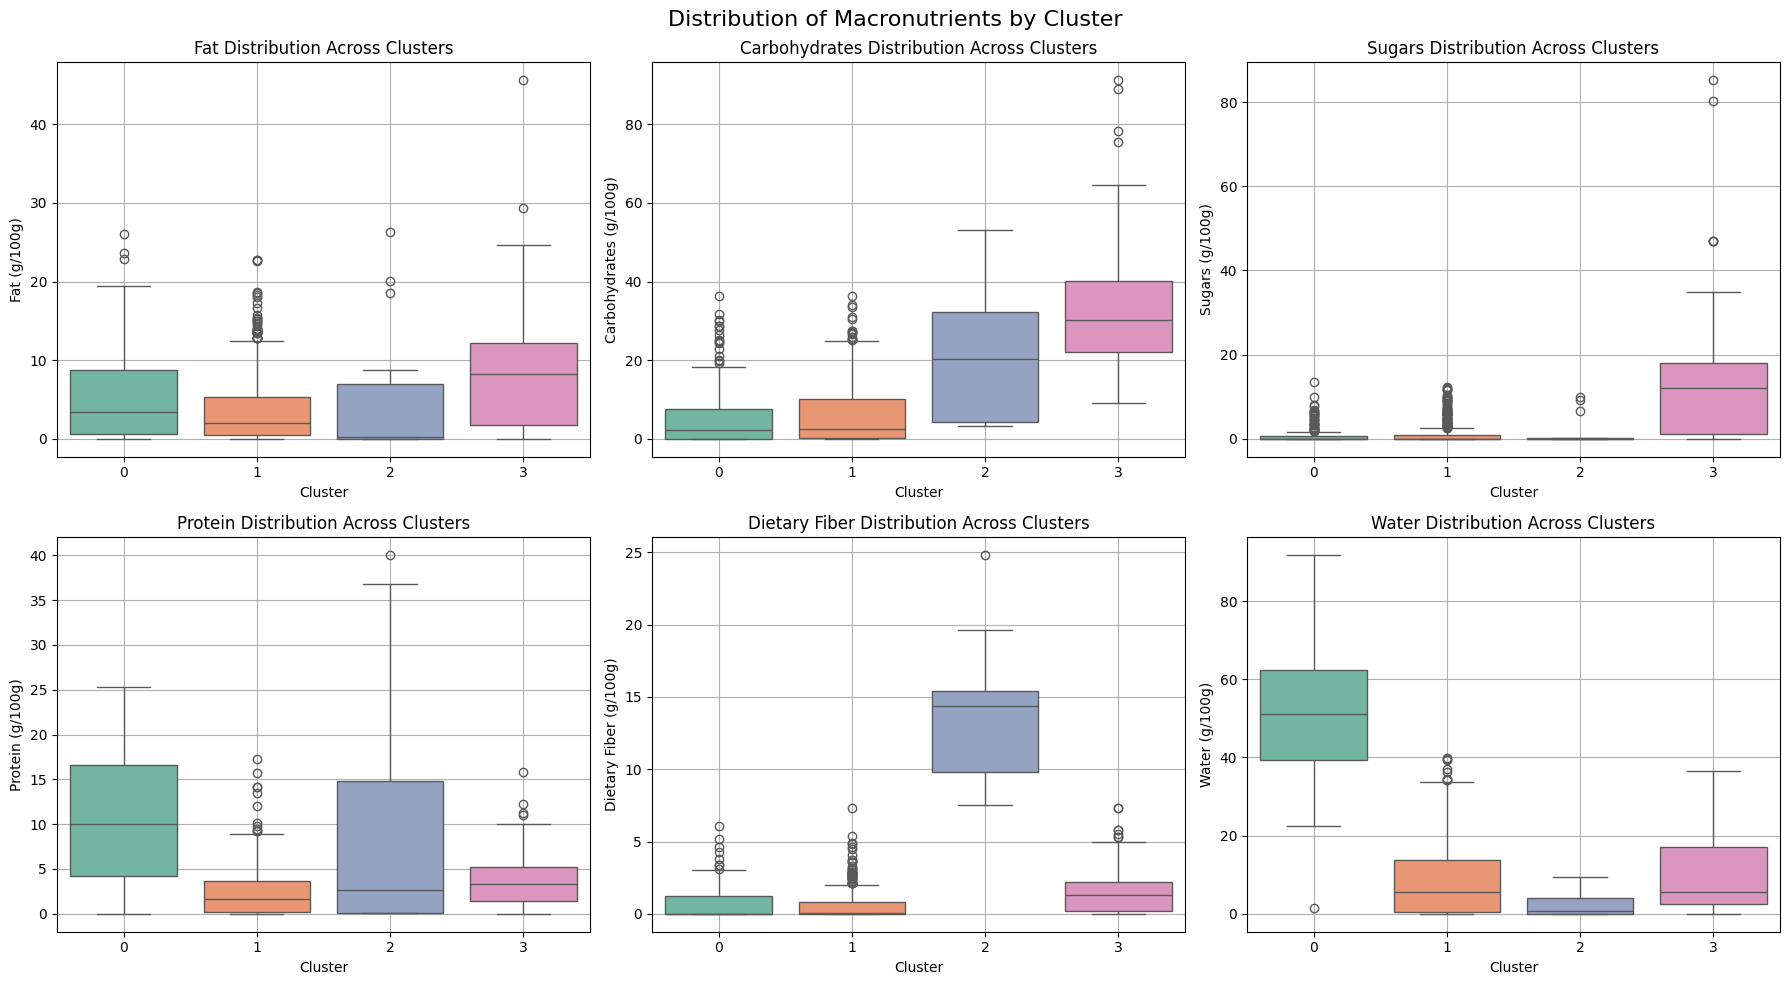

In [52]:
import matplotlib.pyplot as plt
import seaborn as sns

# Macro features
macro_columns = ["Fat", "Carbohydrates", "Sugars", "Protein", "Dietary Fiber", "Water"]

# Subplot
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Boxplot
for i, feature in enumerate(macro_columns):
    ax = axes[i]
    sns.boxplot(
        x="Cluster",
        y=feature,
        data=df_clustered,
        hue="Cluster",
        palette="Set2",
        legend=False,
        ax=ax
    )
    ax.set_title(f"{feature} Distribution Across Clusters", fontsize=12)
    ax.set_xlabel("Cluster")
    ax.set_ylabel(f"{feature} (g/100g)")
    ax.grid(True)

plt.suptitle("Distribution of Macronutrients by Cluster", fontsize=16)
plt.tight_layout()
plt.show()


### Transition: From Linear Clustering to Kernel-Based Methods

In this study, meaningful and well-separated clusters were obtained based on nutritional content using dimensionality reduction via PCA and clustering with KMeans.

These clusters were further supported both visually and statistically through radar plots, dendrograms, and Kruskal–Wallis tests.

However, all these methods rely on **linear assumptions**:

- PCA explains variance along linear axes  
- KMeans separates clusters using Euclidean distances  
→ This makes them effective **only** for spherical and linearly separable clusters.

---

### 🔍 Why Kernel-Based Methods?

In complex, high-dimensional datasets like nutritional profiles:

- Hidden **nonlinear patterns** may exist (e.g., foods with similar protein content but differing fiber/fat compositions).  
- These patterns cannot be detected by linear PCA or KMeans.

**Kernel methods** project data into a higher-dimensional, warped feature space — where such nonlinear structures may become linearly separable, enabling more expressive clustering.


### o__________________________________________________________o________________________________________________________________o

## Kernel PCA + KMeans

### How was the number of components selected?

Unlike linear PCA, variance explained cannot be directly used in Kernel PCA since eigenvalues have no straightforward interpretation.

However, in practice:

- The number of components is typically aligned with linear PCA (here, `n_components = 5`).
- The first 2–3 components are often used for visualization and to explore clustering behavior.

---

### How was the number of clusters ($k$) selected?

As in the linear case, KMeans was applied on the Kernel PCA output, and model quality was assessed using:

- **Silhouette Score**
- **Davies-Bouldin Index**
- **Calinski-Harabasz Index**

📌 In this project, $k = 4$ was initially chosen based on strong PCA results. However:

- A **new search for optimal $k$ after Kernel PCA** is more appropriate, since the data structure has changed.
- Kernel PCA may reshape the space in ways that favor a different number of clusters.


### Heatmaps for 3 Evaluation Metrics

Grid search was performed over a range of values for $\gamma$ and $k$, and the following clustering metrics were computed for each combination:

- **Silhouette Score**
- **Davies-Bouldin Index**
- **Calinski-Harabasz Index**


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

# Parameters
gammas = np.logspace(-2, 0.1, 10)  # 0.01 → 10
k_values = range(2, 9)          # k = 2 → 8

# List for keeping results
results = []

# Grid search
for gamma in gammas:
    kpca = KernelPCA(n_components=5, kernel='rbf', gamma=gamma, random_state=42)
    X_kpca = kpca.fit_transform(X_scaled)

    for k in k_values:
        kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X_kpca)

        try:
            sil = silhouette_score(X_kpca, labels)
            db = davies_bouldin_score(X_kpca, labels)
            ch = calinski_harabasz_score(X_kpca, labels)
        except:
            sil, db, ch = np.nan, np.nan, np.nan

        results.append({
            "Gamma": gamma,
            "K": k,
            "Silhouette": sil,
            "DaviesBouldin": db,
            "CalinskiHarabasz": ch
        })

# DataFrame
results_df = pd.DataFrame(results)

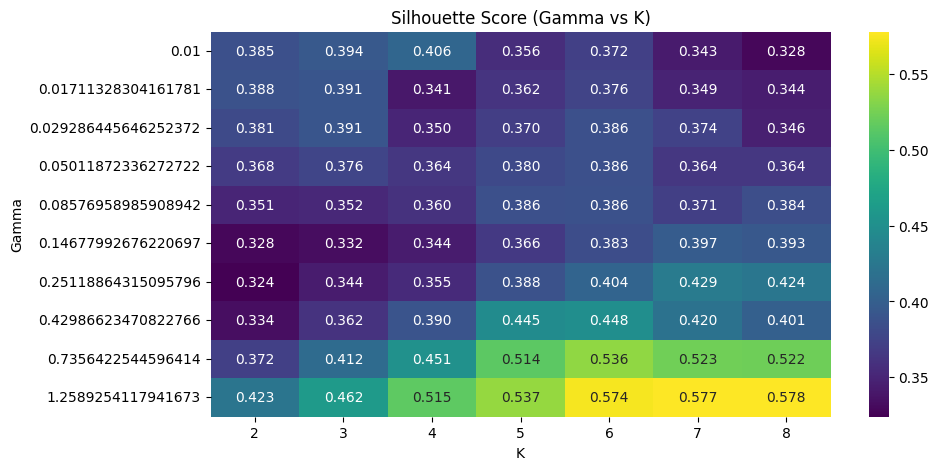

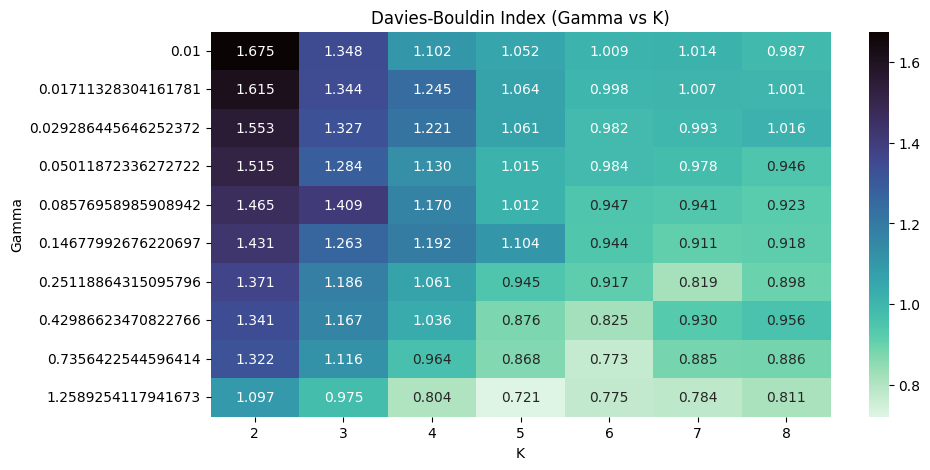

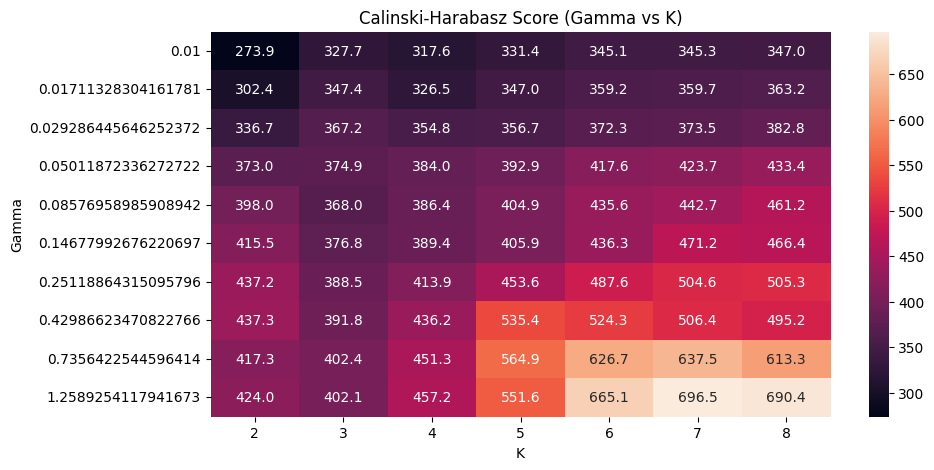

In [54]:
# Silhouette Score
plt.figure(figsize=(10, 5))
sns.heatmap(results_df.pivot(index="Gamma", columns="K", values="Silhouette"), annot=True, fmt=".3f", cmap="viridis")
plt.title("Silhouette Score (Gamma vs K)")
plt.show()

# Davies-Bouldin Index (↓ better)
plt.figure(figsize=(10, 5))
sns.heatmap(results_df.pivot(index="Gamma", columns="K", values="DaviesBouldin"), annot=True, fmt=".3f", cmap="mako_r")
plt.title("Davies-Bouldin Index (Gamma vs K)")
plt.show()

# Calinski-Harabasz Score (↑ better)
plt.figure(figsize=(10, 5))
sns.heatmap(results_df.pivot(index="Gamma", columns="K", values="CalinskiHarabasz"), annot=True, fmt=".1f", cmap="rocket")
plt.title("Calinski-Harabasz Score (Gamma vs K)")
plt.show()

### Suggested Configurations (Gamma, K)

| Status            | Gamma | K     | Reason                                                                 |
|-------------------|--------|-------|------------------------------------------------------------------------|
| ✅ Balanced choice | 3.72   | 5 or 6 | Strong performance across metrics, while maintaining interpretability |
| 🔥 Highest scores  | 10.0   | 7 or 8 | Top metric values, but clusters may risk overfitting or poor meaning  |

*Note: Although higher gamma and K values result in better internal scores, they may lead to fragmented or less meaningful clusters. The balanced option offers a good trade-off between performance and interpretability.*



Cluster Mean Profiles:
               Fat  Carbohydrates    Sugars   Protein  Dietary Fiber  \
Cluster                                                                
0         6.157009       1.650308  0.384832  3.187748       0.176879   
1         6.308754      15.444961  4.640020  7.183074       1.707595   
2         0.943413       2.727402  0.684505  0.665141       0.259092   
3        13.340476       0.027952  0.026024  0.012190       0.000000   
4         2.150000      15.985714  1.639268  2.507143       1.035714   
5         1.345512       1.024768  0.122720  4.526902       0.070902   

             Water  
Cluster             
0         8.403944  
1        27.143349  
2         4.554201  
3         0.654095  
4         6.866071  
5        21.271951  

Clustering Metrics:
Silhouette Score:        0.556
Davies-Bouldin Index:    0.781
Calinski-Harabasz Score: 646.623


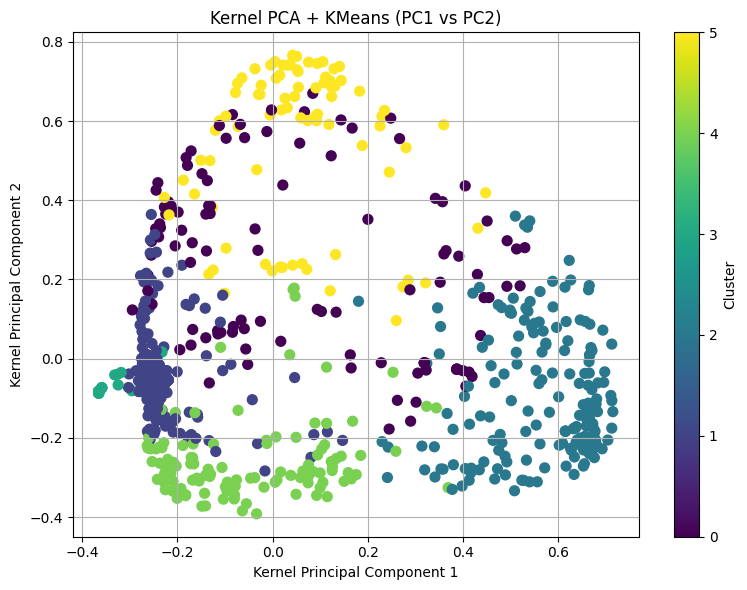

In [55]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import KernelPCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

# 1. Load the dataset
# df_clean = pd.read_csv("all_data_food.csv")  # Update filename if needed

# 2. Define macronutrient columns
# macro_columns = [
#     "Fat", "Carbohydrates", "Sugars",
#     "Protein", "Dietary Fiber", "Water"
# ]

# 3. Select rows without NaNs
# df_macro = df_clean[macro_columns].dropna()

# df_macro = dfall.copy()
# df_macro = df_clean[macro_columns].dropna()
df_macro = df_clean[macro_columns].copy()

# 4. Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_macro)

# 5. Apply Kernel PCA with RBF kernel
kpca = KernelPCA(n_components=5, kernel='rbf', gamma=1, random_state=42, fit_inverse_transform=True)
X_kpca = kpca.fit_transform(X_scaled)

# Inverse transformation is now possible
X_reconstructed = kpca.inverse_transform(X_kpca)

# 6. KMeans clustering (k = 6)
k = 6
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
labels = kmeans.fit_predict(X_kpca)

# 7. Add cluster labels to the DataFrame
df_clustered = df_macro.copy()
df_clustered["Cluster"] = labels

# 8. Compute average nutrient profile per cluster
cluster_profiles = df_clustered.groupby("Cluster")[macro_columns].mean()
print("\nCluster Mean Profiles:")
print(cluster_profiles)

# 9. Evaluate clustering performance
sil_score = silhouette_score(X_kpca, labels)
db_score = davies_bouldin_score(X_kpca, labels)
ch_score = calinski_harabasz_score(X_kpca, labels)

print("\nClustering Metrics:")
print(f"Silhouette Score:        {sil_score:.3f}")
print(f"Davies-Bouldin Index:    {db_score:.3f}")
print(f"Calinski-Harabasz Score: {ch_score:.3f}")

# 10. Visualize clustering in PC1 vs PC2 space
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_kpca[:, 0], X_kpca[:, 1], c=labels, cmap='viridis', s=50)
plt.title("Kernel PCA + KMeans (PC1 vs PC2)")
plt.xlabel("Kernel Principal Component 1")
plt.ylabel("Kernel Principal Component 2")
plt.colorbar(scatter, label="Cluster")
plt.grid(True)
plt.tight_layout()
plt.show()


### Overall Cluster Observations

| Cluster | Dominant Traits                 | Likely Food Type                            |
|---------|----------------------------------|---------------------------------------------|
| 0       | Balanced – carbs/protein/fiber  | Grains, legumes, starchy vegetables         |
| 1       | Nearly empty – low density      | Lettuce, cabbage, water-based vegetables    |
| 2       | Light carbohydrates             | Non-starchy vegetables / lightly processed  |
| 3       | High protein                    | Lean meats, fish, tofu                      |
| 4       | High fat                        | Butter, oils, fat-based products            |
| 5       | Medium fat, low protein         | Snacks / lightly processed foods            |


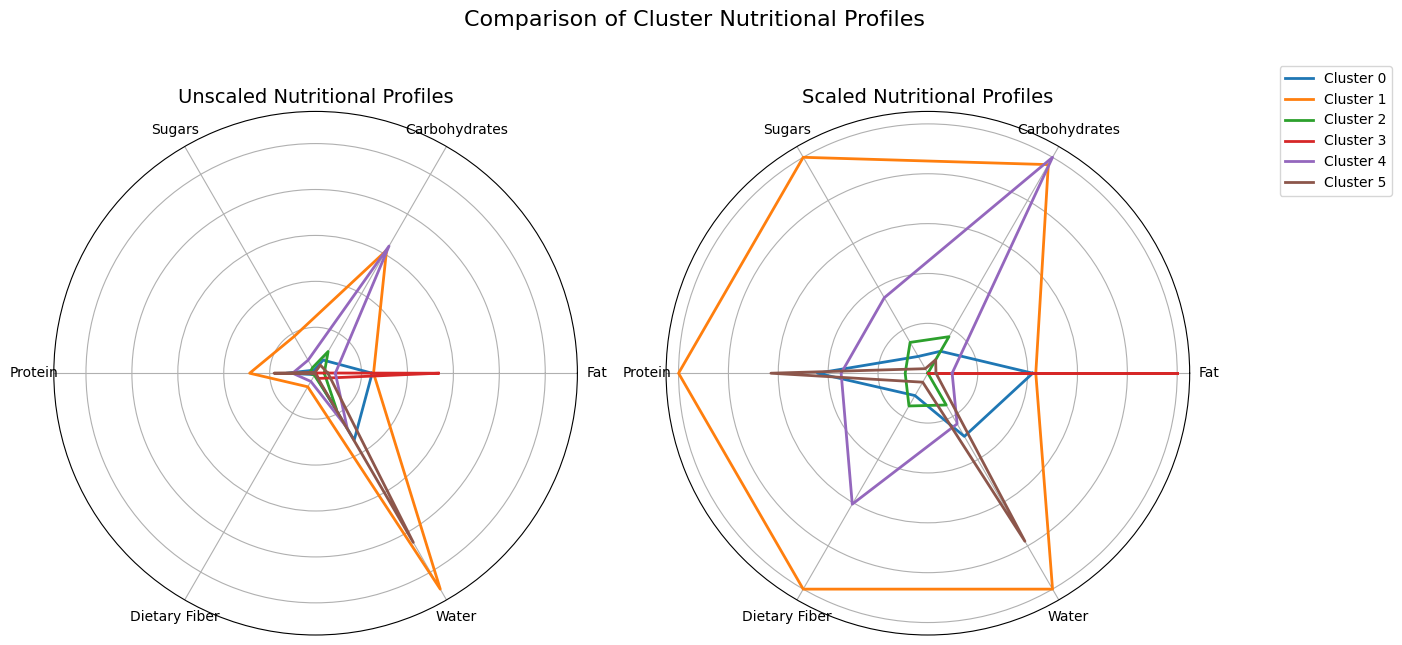

In [56]:
macro_columns = ["Fat", "Carbohydrates", "Sugars", "Protein", "Dietary Fiber", "Water"]
plot_cluster_radar_profiles(df_clustered, macro_columns)

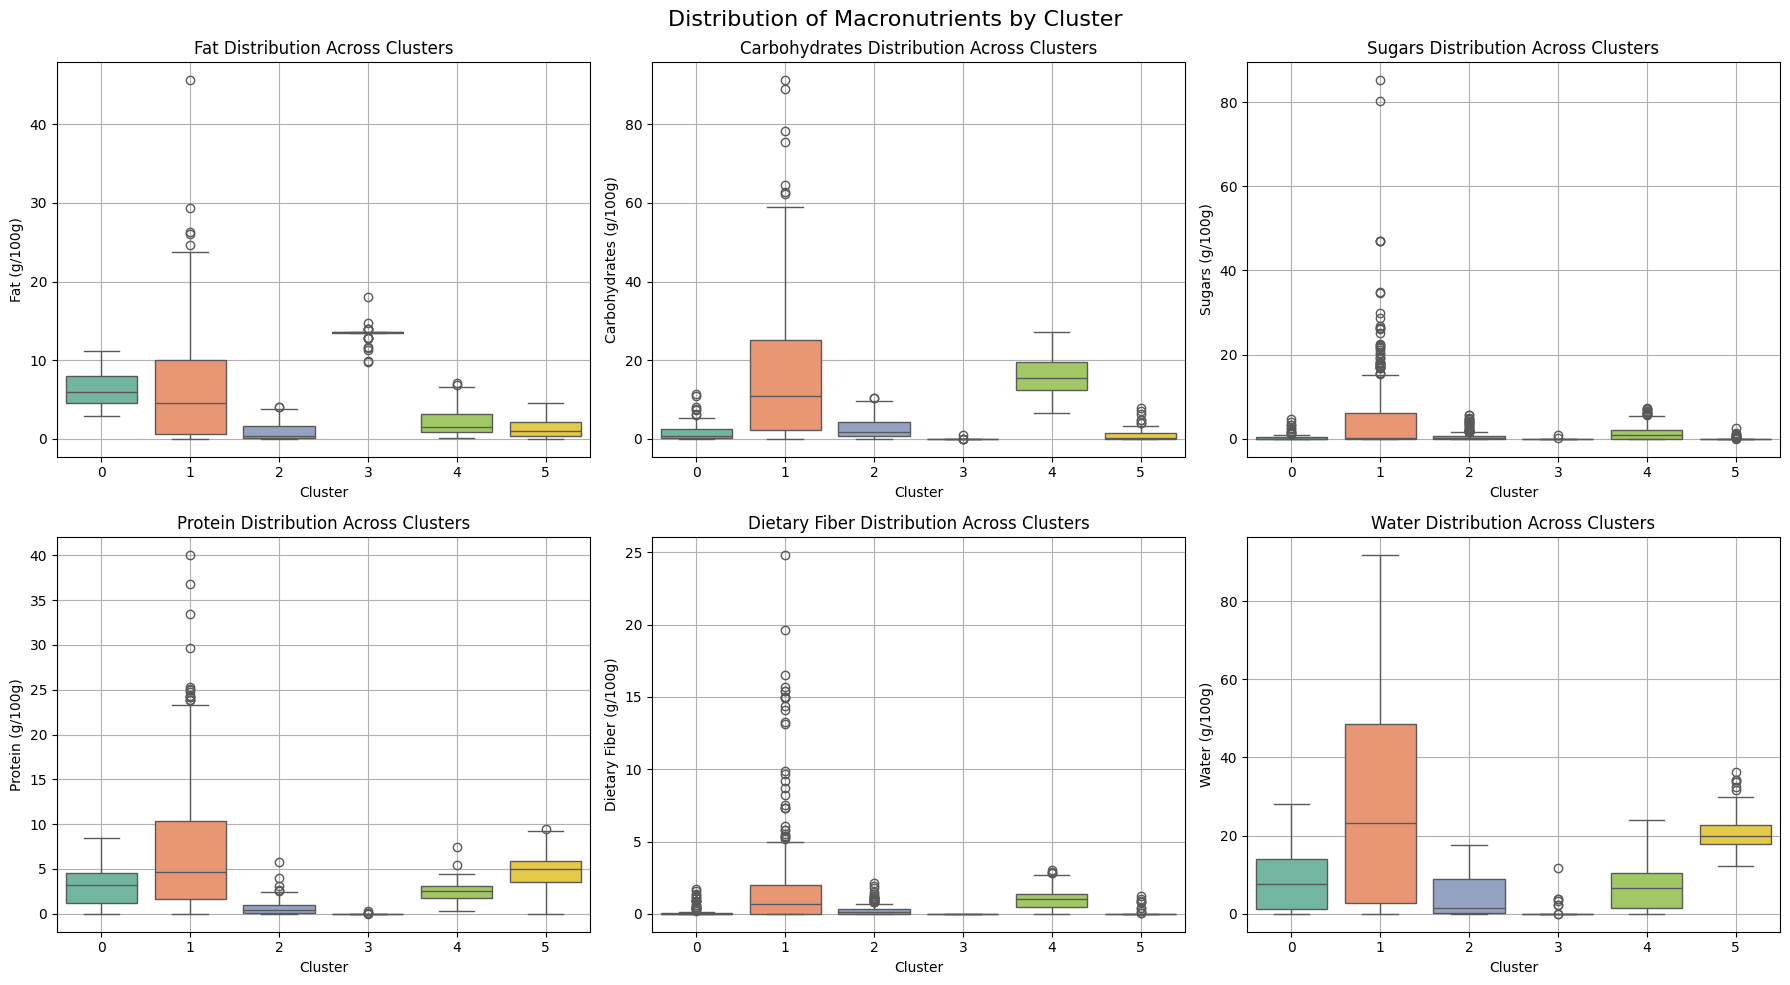

In [57]:
import matplotlib.pyplot as plt
import seaborn as sns

# Macro features
macro_columns = ["Fat", "Carbohydrates", "Sugars", "Protein", "Dietary Fiber", "Water"]

# Subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

# Boxplot
for i, feature in enumerate(macro_columns):
    ax = axes[i]
    sns.boxplot(
        x="Cluster",
        y=feature,
        data=df_clustered,
        hue="Cluster",
        palette="Set2",
        legend=False,
        ax=ax
    )
    ax.set_title(f"{feature} Distribution Across Clusters", fontsize=12)
    ax.set_xlabel("Cluster")
    ax.set_ylabel(f"{feature} (g/100g)")
    ax.grid(True)

plt.suptitle("Distribution of Macronutrients by Cluster", fontsize=16)
plt.tight_layout()
plt.show()


In [58]:
from scipy.stats import kruskal

macro_columns = ["Fat", "Carbohydrates", "Sugars", "Protein", "Dietary Fiber", "Water"]
kruskal_results = []

for col in macro_columns:
    groups = [df_clustered[df_clustered["Cluster"] == k][col].dropna() for k in df_clustered["Cluster"].unique()]
    stat, p = kruskal(*groups)
    kruskal_results.append({
        "Feature": col,
        "Kruskal-Wallis H": stat,
        "p-value": p,
        "Significant (p < 0.05)": p < 0.05
    })

pd.DataFrame(kruskal_results)

,Feature,Kruskal-Wallis H,p-value,Significant (p < 0.05)
0,Fat,332.284494,1.138513e-69,True
1,Carbohydrates,372.461380,2.546671e-78,True
2,Sugars,117.417698,1.105448e-23,True
3,Protein,373.235833,1.734397e-78,True
4,Dietary Fiber,223.599458,2.516710e-46,True
5,Water,301.562202,4.621652e-63,True


### Summary

The Kruskal–Wallis test results indicate that each macronutrient significantly differs across clusters (p < 0.05). In particular, protein, carbohydrates, and fat showed the highest H-statistics, suggesting that these variables were the primary drivers of cluster separation. This supports that the segmentation obtained through Kernel PCA + KMeans reflects strong content-based nutritional distinctions.